Importing Libraries

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.python.client import device_lib
import tensorflow as tf
import os
import cv2
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

VGG16 Image Orientation Detector: Setup & Helper functions

In [ ]:
class VGG16ImageOrientationDetector():
    def __init__(self, w=224, h=224, nc=4):
        
        # image shape = 224*224 and number of rotation classes = 4 (0, 90, 180, 270)
        self.img_width=w
        self.img_height=h
        self.num_classes=nc

    def plot_history(self, history, yrange):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))
        
        # Plot training and validation accuracy per epoch
        plt.plot(epochs, acc)
        plt.plot(epochs, val_acc)
        plt.title('Training and validation accuracy')
        plt.ylim(yrange)

        plt.savefig('Acc.png')

        # Plot training and validation loss per epoch
        plt.figure()

        plt.plot(epochs, loss)
        plt.plot(epochs, val_loss)
        plt.title('Training and validation loss')
    
        plt.savefig('Loss.png')


    def createVGG16ImageOrientationDetector(self):
        vgg16 = keras.applications.vgg16 # Pretrained vgg16 present in keras
        conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) # Exclude the fully connected layers of the VGG 16 model

        # Custom Fully connected layer
        x = keras.layers.Flatten()(conv_model.output) # Flatten the output of the convolutional layer into a single vector
        x = keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01), bias_regularizer=keras.regularizers.l2(0.01))(x)
        x = keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01), bias_regularizer=keras.regularizers.l2(0.01))(x)
        x = keras.layers.Dropout(0.5)(x)
        predictions = keras.layers.Dense(self.num_classes, activation='softmax')(x) # Final multi-class classification output

        full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

        for layer in conv_model.layers:
            layer.trainable = False

        return full_model

    def train(self, model):
        sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
        data_generator=ImageDataGenerator(preprocessing_function=preprocess_input)
        test_datagen=ImageDataGenerator()

        train_generator=data_generator.flow_from_directory(
                                    directory='/kaggle/input/dataset-5/Final_split_data/train',
                                    classes=['-1','0','1','2'],
                                    # labels='inferred',
                                    # label_mode='int',
                                    color_mode='rgb',
                                    batch_size=64,
                                    seed=42,
                                    shuffle=True,
                                    interpolation='nearest',
                                    target_size=(self.img_height,self.img_width))

        valid_generator=data_generator.flow_from_directory(
                                    directory='/kaggle/input/dataset-5/Final_split_data/val',
                                    classes=['-1','0','1','2'],
                                    color_mode='rgb',
                                    batch_size=64,
                                    seed=42,
                                    shuffle=True,
                                    interpolation='nearest',
                                    target_size=(self.img_height,self.img_width))



        test_generator=test_datagen.flow_from_directory(
                                    directory='/kaggle/input/dataset-5/Final_split_data/test',
                                    classes=['-1','0','1','2'],
                                    color_mode='rgb',
                                    batch_size=1,
                                    seed=42,
                                    shuffle=True,
                                    interpolation='nearest',
                                    target_size=(self.img_height,self.img_width))

        print('Training.')
        print()

        model.summary()
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

        mcp_save = ModelCheckpoint(os.path.join(os.getcwd(),'weights/mdl_wtsn8.hdf5'), save_best_only=True, monitor='val_loss', mode='min')
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')

        history = model.fit_generator(
            train_generator,
            validation_data = valid_generator,
            validation_steps=valid_generator.samples//valid_generator.batch_size,
            steps_per_epoch=train_generator.samples//train_generator.batch_size,
            callbacks=[mcp_save, reduce_lr_loss],
            epochs=100
        )

        print('Predicting')
        loss, acc = model.evaluate(test_generator, verbose=1)
        print('Loss: ',loss)
        print('Accuracy: ',acc)
        
        preds = model.predict(test_generator)
        pred_labels = np.argmax(preds, axis=1)
        actual_labels = test_generator.classes
        target_names = ['Already fine', '90 degree clockwise', '180 degree clockwise', '90 degree anticlockwise']
        print(classification_report(actual_labels, pred_labels, target_names=target_names))
                
        
        return history

Training & Plotting graphs


58889256/58889256 [==============================] - 1s 0us/step
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5

Found 9253 images belonging to 4 classes.
Found 1541 images belonging to 4 classes.
Found 4631 images belonging to 4 classes.
Training.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                     

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
144/144 [==============================] - 96s 540ms/step - loss: 4.9751 - acc: 0.5051 - val_loss: 3.5238 - val_acc: 0.6302 - lr: 0.0010
Epoch 2/100
144/144 [==============================] - 50s 346ms/step - loss: 3.1197 - acc: 0.6988 - val_loss: 2.6970 - val_acc: 0.7539 - lr: 0.0010
Epoch 3/100
144/144 [==============================] - 53s 368ms/step - loss: 2.3343 - acc: 0.7701 - val_loss: 2.1726 - val_acc: 0.7565 - lr: 0.0010
Epoch 4/100
144/144 [==============================] - 51s 355ms/step - loss: 1.8305 - acc: 0.8075 - val_loss: 1.8577 - val_acc: 0.7819 - lr: 0.0010
Epoch 5/100
144/144 [==============================] - 54s 371ms/step - loss: 1.4350 - acc: 0.8501 - val_loss: 1.5599 - val_acc: 0.7923 - lr: 0.0010
Epoch 6/100
144/144 [==============================] - 49s 340ms/step - loss: 1.1866 - acc: 0.8743 - val_loss: 1.5009 - val_acc: 0.7852 - lr: 0.0010
Epoch 7/100
144/144 [==============================] - 55s 377ms/step - loss: 0.9722 - acc: 0.8972 - val_l

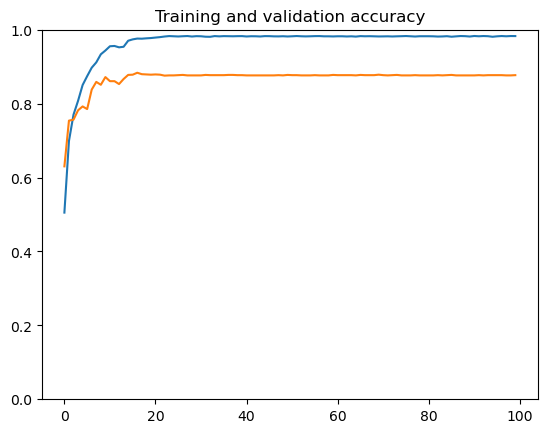

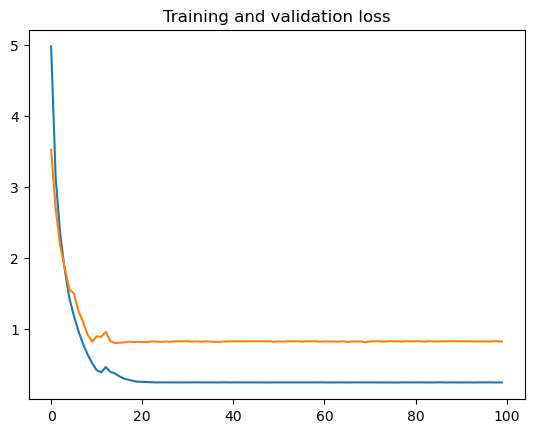

In [1]:
if __name__ == '__main__':
    RRN=VGG16ImageOrientationDetector()
    print()
    model=RRN.createVGG16ImageOrientationDetector() # model creation
    history=RRN.train(model) # training model

    print('Plotting accuracy and loss graphs')
    RRN.plot_history(history, yrange=(0,1))

    print('Finished')



Testing

In [2]:
test_datagen=ImageDataGenerator()
test_generator1=test_datagen.flow_from_directory(
                                    directory='/kaggle/input/dataset-test/test_to_fix_split',
                                    classes=['-1','0','1','2'],
                                    color_mode='rgb',
                                    batch_size=1,
                                    seed=42,
                                    shuffle=False,
                                    interpolation='nearest',
                                    target_size=(224,224))

Found 9 images belonging to 4 classes.


In [4]:
loss, acc = model.evaluate(test_generator1, verbose=1)
# print('On test set: ')
preds = model.predict(test_generator1)
pred_labels = np.argmax(preds, axis=1)
actual_labels = test_generator1.classes

pred_labels1 = []
for i in pred_labels:
    if(i==0):
        pred_labels1.append('Already fine')
    elif(i==1):
        pred_labels1.append('90 degree clockwise')
    elif(i==2):
        pred_labels1.append('180 degree clockwise')
    elif(i==3):
        pred_labels1.append('90 degree anticlockwise')

actual_labels1 = []
for i in actual_labels:
    if(i==0):
        actual_labels1.append('Already fine')
    elif(i==1):
        actual_labels1.append('90 degree clockwise')
    elif(i==2):
        actual_labels1.append('180 degree clockwise')
    elif(i==3):
        actual_labels1.append('90 degree anticlockwise')
    
# actual_labels.map({0:'Already fine', 1: '90 degree clockwise', 2 : '180 degree clockwise', 3 : '90 degree anticlockwise'})

# Print the predicted and actual labels
print("Predicted labels: ", pred_labels1)
print("Actual labels: ", actual_labels1)
print('')
print("Predicted labels: ", pred_labels)
print("Actual labels: ", actual_labels)



9/9 [==============================] - 0s 10ms/step
Predicted labels:  ['Already fine', 'Already fine', 'Already fine', 'Already fine', '90 degree anticlockwise', '180 degree clockwise', '180 degree clockwise', '90 degree anticlockwise', '90 degree clockwise']
Actual labels:  ['Already fine', 'Already fine', 'Already fine', 'Already fine', '90 degree clockwise', '180 degree clockwise', '180 degree clockwise', '90 degree anticlockwise', '90 degree anticlockwise']

Predicted labels:  [0 0 0 0 3 2 2 3 1]
Actual labels:  [0 0 0 0 1 2 2 3 3]


In [5]:
test_generator=test_datagen.flow_from_directory(
                                    directory='/kaggle/input/dataset-5/Final_split_data/test',
                                    classes=['-1','0','1','2'],
                                    color_mode='rgb',
                                    batch_size=1,
                                    seed=42,
                                    shuffle=True,
                                    interpolation='nearest',
                                    target_size=(224,224))
len(test_generator)

loss, acc = model.evaluate(test_generator, verbose=1)

Found 4631 images belonging to 4 classes.
4631/4631 [==============================] - 48s 10ms/step - loss: 1.1773 - acc: 0.8337
